<a href="https://colab.research.google.com/github/eking03/Data110-Fall2025/blob/main/Data110_Final_IDW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Interpolation Attempt

Follows tutorial from https://medium.com/data-science/3-best-methods-for-spatial-interpolation-912cab7aee47

Full code available at https://github.com/alexxxroz/Medium/blob/main/SpatialInterpolation.ipynb

## Importing libraries

In [1]:
!pip install cartopy regionmask

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import regionmask

## Getting data

Code from official final project draft notebook.

In [3]:
air = pd.read_csv('https://raw.githubusercontent.com/eking03/Data110-Fall2025/refs/heads/main/Data/Air_Quality_Purple_Air_Sensors.csv')

In [4]:
air = air[['SENSOR_INDEX', 'REPORTED_DATETIME', 'HUMIDITY', 'TEMPERATURE', 'PM2_5', 'PM2_5_CF_1', 'PM2_5_ALT', 'VOC', 'LONGITUDE', 'LATITUDE', 'OBJECTID']]

air = air.rename(columns={'PM2_5' : 'PM', 'PM2_5_CF_1' : 'PM_CF1', 'PM2_5_ALT' : 'PM_ALT'})

air['REPORTED_DATETIME'] = air['REPORTED_DATETIME'].str.replace('+00', '')
air['REPORTED_DATETIME'] = air['REPORTED_DATETIME'].str.replace('/', '-')

air['REPORTED_DATETIME'] = pd.to_datetime(air['REPORTED_DATETIME'])

air['MONTH'] = air['REPORTED_DATETIME'].dt.month
air['HOUR'] = air['REPORTED_DATETIME'].dt.hour

In [5]:
sensor_gdf = air[['SENSOR_INDEX', 'LATITUDE', 'LONGITUDE']].groupby(['SENSOR_INDEX']).mean().reset_index()
sensor_gdf = gpd.GeoDataFrame(sensor_gdf, geometry = gpd.points_from_xy(sensor_gdf.LONGITUDE, sensor_gdf.LATITUDE), crs="EPSG:4236")
sensor_gdf = sensor_gdf[['SENSOR_INDEX', 'geometry']]

In [6]:
air_gdf = pd.merge(air, sensor_gdf, on='SENSOR_INDEX')
air_gdf = gpd.GeoDataFrame(air_gdf, geometry = air_gdf.geometry, crs="EPSG:4326")

In [7]:
air_gdf = air_gdf[air_gdf['PM_CF1'].notnull()]
air_gdf = air_gdf[air_gdf['TEMPERATURE'] < 150]

In [8]:
gdf = air_gdf[['SENSOR_INDEX', 'geometry', 'PM']].groupby(['SENSOR_INDEX', 'geometry']).mean().reset_index()
gdf = gpd.GeoDataFrame(gdf, geometry = gdf.geometry, crs="EPSG:4326")

In [9]:
# setting PM variable name to TAVG to match demo (who is interpolating temperature averages)
gdf['TAVG'] = gdf['PM']

In [10]:
# re-establishing LATITUDE and LONGITUDE columns for NN function
gdf['LATITUDE'] = gdf['geometry'].y
gdf['LONGITUDE'] = gdf['geometry'].x

Back to closely following article tutorial:

In [11]:
shape = gpd.read_file('https://opendata.dc.gov/api/download/v1/items/7241f6d500b44288ad983f0942b39663/shapefile?layers=10')
# shape.plot()

shape = shape.to_crs('EPSG:4326')

Changing CRS from shapefile default (EPSG:3857) to the CRS in the demo (EPSG:4326)

In [12]:
# based on shape.total_bounds = array([-77.11979522,  38.79164435, -76.90914996,  38.99596804])
LAT, LON = np.arange(38.78, 39.01, 0.01), np.arange(-77.12, -76.90, 0.01)

In [13]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


## I. Nearest Neighbor (NN)

In [14]:
def Euclidean(x1,x2,y1,y2):
  return ((x1-x2)**2+(y1-y2)**2)**0.5

def NN(data, LAT, LON):
  array = np.empty((LAT.shape[0], LON.shape[0]))

  for i, lat in enumerate(LAT):
    for j, lon in enumerate(LON):
      idx = data.apply(lambda row: Euclidean(row.LONGITUDE, lon, row.LATITUDE, lat), axis = 1).argmin()
      array[i,j] = data.loc[idx, 'TAVG']
  return array

In [21]:
t2m = NN(gdf, LAT, LON)
t2m.shape

(23, 22)

In [22]:
ds = xr.Dataset(
    {'TAVG': (['lat', 'lon'], t2m)},
    coords={'lat': LAT, 'lon': LON})
ds

<xarray.Dataset> Size: 4kB
Dimensions:  (lat: 23, lon: 22)
Coordinates:
  * lat      (lat) float64 184B 38.78 38.79 38.8 38.81 ... 38.98 38.99 39.0
  * lon      (lon) float64 176B -77.12 -77.11 -77.1 ... -76.93 -76.92 -76.91
Data variables:
    TAVG     (lat, lon) float64 4kB 7.299 7.299 7.299 ... 7.792 7.792 7.792

In [24]:
shape['new_column'] = 0
sw = shape.dissolve(by='new_column')['geometry']
rg = regionmask.mask_3D_geopandas(sw, lon_or_obj=ds.lon, lat=ds.lat)

## II. Inverse Distance Weighting (IDW)

In [25]:
def IDW(data, LAT, LON, betta=2):
  array = np.empty((LAT.shape[0], LON.shape[0]))

  for i, lat in enumerate(LAT):
    for j, lon in enumerate(LON):
      weights = data.apply(lambda row: Euclidean(row.LONGITUDE, lon, row.LATITUDE, lat)**(-betta), axis = 1)
      z = sum(weights*data.TAVG)/weights.sum()
      array[i,j] = z
  return array

In [26]:
t2m = IDW(gdf, LAT, LON)
ds = xr.Dataset(
    {'TAVG': (['lat', 'lon'], t2m)},
    coords={'lat': LAT, 'lon': LON})

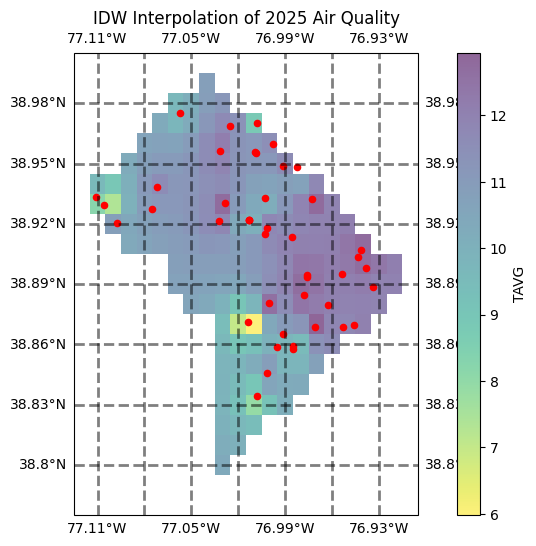

In [41]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10, 6))
#shape.plot(ax=ax, color='black')
ds.where(rg).TAVG.plot(ax=ax, alpha=0.6, cmap='viridis_r')
gdf.plot(ax=ax, color='r', markersize=20)
ax.gridlines(draw_labels=True,linewidth=2, color='black', alpha=0.5, linestyle='--')
plt.title('IDW Interpolation of 2025 Air Quality')
plt.show()